# Greedy Iterated Local Search Graph Sampling 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

In [2]:
from itertools import islice
import numpy as np
import pylab as plt
import math

def plot_scores(scores, num_graphs_per_plot = 4):
    num_plots = int(math.ceil(len(scores)/float(num_graphs_per_plot)))
    for i in range(num_plots):
        plt.figure(figsize=(13,5))
        start=i*num_graphs_per_plot
        end=i*num_graphs_per_plot+num_graphs_per_plot
        for j,score in enumerate(scores[start:end]):
            data = score
            plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot))
            plt.plot(data, linestyle='None', markerfacecolor='white', markeredgecolor='k', marker='o', markeredgewidth=2,markersize=6)
        plt.legend(loc='upper left')
        plt.ylim(-.1,1.1)
        plt.grid()
        plt.show()

# Set up source of graphs

In [3]:
assay_id = '651610' #apr93 23k mols
assay_id = '1834'   #apr90 500 mols
assay_id = '624466' #apr88 p5k n23k
assay_id = '588350' #apr86 p1k n600
assay_id = '449764' #apr85
assay_id = '492952' #apr85
assay_id = '463112' #apr82
assay_id = '463213' #apr70
assay_id = '119'    #apr60 30k mols
assay_id = '1224857'#apr10
assay_id = '2326'   #apr03 200k mols

#-------------------------------------------------
# choose
assay_id = '588350' #apr86 p1k n600

In [4]:
from toolz import curry, pipe
from eden_chem.io.pubchem import download
from eden_chem.obabel import load as babel_load

download_active = curry(download)(active=True)

def get_pos_graphs(assay_id): return pipe(assay_id, download_active, babel_load, list)

def get_graphs(): return get_pos_graphs(assay_id)

### set up a scoring system :D 

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

class DistanceEstimator():
    
    def __init__(self, reference_vecs, desired_distances):
        self.reference_vecs = reference_vecs
        self.desired_distances = desired_distances
        # compute weights as a normalized reciprocals of distances 
        d = np.array(desired_distances)
        dn = d/np.max(d)
        idn = 1/dn
        nidn = idn/np.max(idn)
        self.weights = nidn
        
    def fit(self,arg,**args):
        # the init phase is all that is needed for fitting
        pass
    
    def predict(self, vector):
        # compute the distance to each of the reference vectors
        distances = euclidean_distances(vector, self.reference_vecs)[0]
        # score the discrepancy w.r.t. the desired distances
        abs_diff = np.abs(distances - self.desired_distances)
        weighted_abs_diff = np.multiply(self.weights, abs_diff)
        discrepancy = np.mean(weighted_abs_diff)
        # convert it to a similarity value to maximize
        similarity = 1/(1+discrepancy)
        return similarity

In [6]:
from eden.graph import Vectorizer
vec = Vectorizer(complexity=3, n_jobs=1, normalization=False, inner_normalization=False)
graphs = get_graphs()

# Select a reference graph and its neighbors

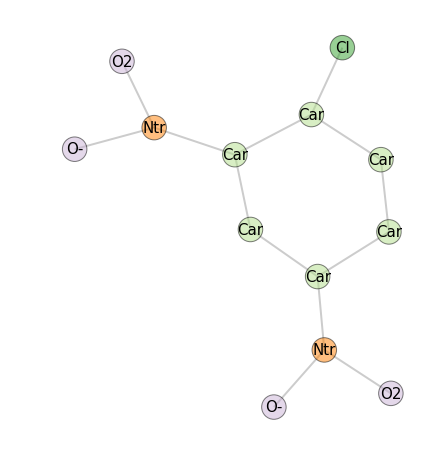

id:668 (56.97) id:826 (59.14) id:1045 (59.57) id:441 (60.26)

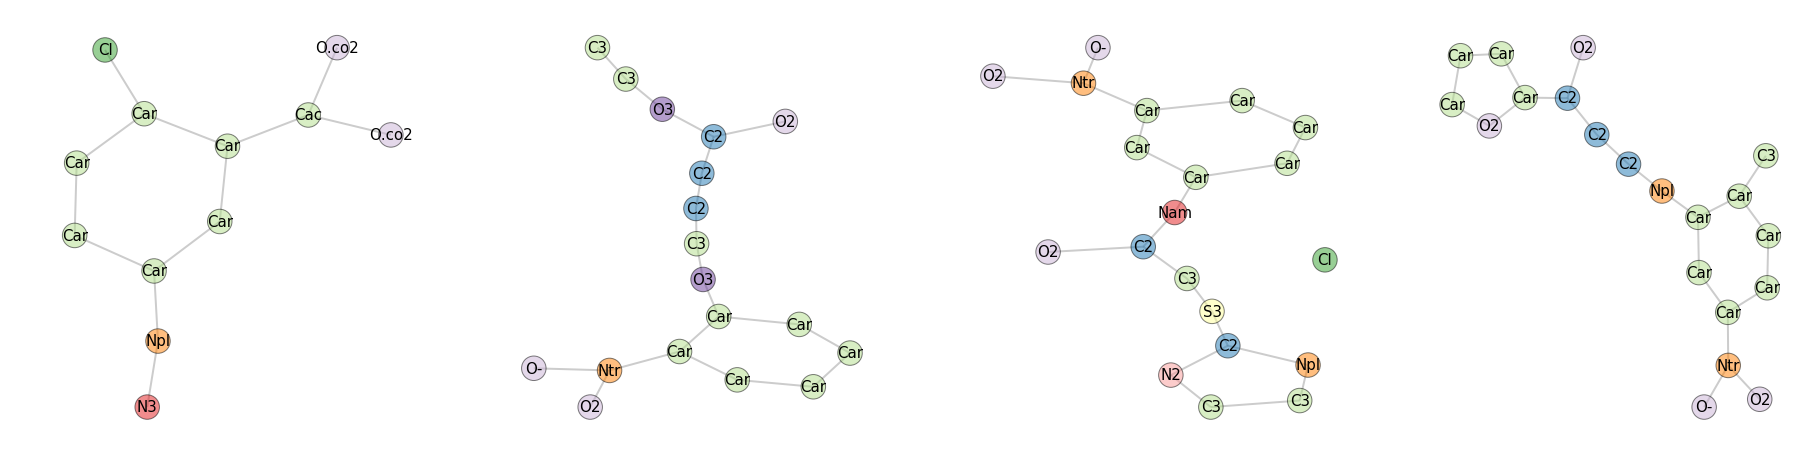

CPU times: user 8.48 s, sys: 212 ms, total: 8.69 s
Wall time: 8.8 s



In [7]:
%%time
reference_graph = graphs[0]
from eden.display import map_labels_to_colors
label_colors = map_labels_to_colors(graphs)

from graphlearn.utils import draw
draw_params=dict(n_graphs_per_line=6, size=8, 
                colormap='Paired', vertex_color='_labels_', 
                vertex_color_dict=label_colors,
                vertex_alpha=0.5, edge_alpha=0.2)
draw.graphlearn([reference_graph], **draw_params) 

n_neighbors = 4
from sklearn.neighbors import NearestNeighbors
X = vec.transform(graphs)
nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(X)
reference_x = vec.transform([reference_graph])
distances, indices = nbrs.kneighbors(reference_x)

neighbor_graphs = [graphs[i] for i in list(indices[0])[1:]]
desired_distances = distances[0][1:]
reference_vecs = vec.transform(neighbor_graphs)

for i,d in zip(list(indices[0]), list(distances[0]))[1:]: print('id:%d (%.2f)'%(i,d)), 

draw.graphlearn(neighbor_graphs, **draw_params) 

In [8]:
est = DistanceEstimator(reference_vecs, desired_distances)

# Setup the greedy ILS 

In [9]:
from graphlearn.graphlearn import  Sampler
from graphlearn.utils.neighbors import graph_neighbors
import random

class GreedyIteratedLocalSearchSampler(Sampler):
    
    def _greedy_step(self, graph):
        grammar = self.lsgg
        neighbors = list(graph_neighbors(graph, grammar, self.graph_transformer))
        max_score, max_graph = max(map(lambda g:(self._score(g),g), neighbors))
        return max_graph
    
    def _random_step(self, graph):
        grammar = self.lsgg
        neighbors = list(graph_neighbors(graph, grammar, self.graph_transformer))
        return random.choice(neighbors)
    
    def _random_steps(self, graph, n_steps=1):
        next_graph = graph
        for i in range(n_steps):
            next_graph = self._random_step(next_graph)
        return next_graph
    
    def _choose_proposal(self, graph):
        # if the objective is reached then stop
        _epsilon = 0.1
        if self._score(graph) > 1 - _epsilon:
            return graph
        # else find the best neighbor
        best_neighbor = self._greedy_step(graph)
        # if it is an improvement then greedily select it
        if self._score(best_neighbor) > self._score(graph):
            return best_neighbor
        # else select a random neighbor
        else:
            # print 'random jump',
            random_neighbor = self._random_steps(graph, n_steps=1)
            s = self._score(random_neighbor)
            return random_neighbor

# Setup the sampler

In [10]:
%%time
from graphlearn.localsubstitutablegraphgrammar import LocalSubstitutableGraphGrammar as lsgg

sampler=GreedyIteratedLocalSearchSampler(
    estimator=est,
    vectorizer=vec,
    grammar=lsgg(radius_list=[0,1,2,3],
                 thickness_list=[1],
                 min_cip_count=2,min_interface_count=2), 
    accept_static_penalty=-1,#needed to accept not improving moves
    n_samples=75,
    n_jobs=1,
    n_steps=75,
    include_seed=True,
    keep_duplicates=True,
    monitor=True,
    proposed_graphs_per_step=1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 51 µs


# Fit the grammar

In [11]:
%%time
sampler.fit(graphs)
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))

#instances: 1232   #interfaces: 1340   #cores: 4800   #core-interface-pairs: 10128
CPU times: user 31.5 s, sys: 3.7 s, total: 35.2 s
Wall time: 37.2 s


# Sample and show generated graphs

In [12]:
import multiprocessing
from eden import apply_async

def sample_graph(seed_graph, sampler):
    samples = list(sampler.transform([seed_graph]))
    scores = sampler.monitors[0].sampling_info['score_history']
    return samples, scores
    
def sample_graphs(seed_graphs, sampler):
    pool = multiprocessing.Pool()
    sample_graphs_scores = [apply_async(pool,sample_graph,args=(seed_graph, sampler)) for seed_graph in seed_graphs]
    sample_graphs_scores_list = [p.get() for p in sample_graphs_scores]
    pool.close()
    pool.join()
    return sample_graphs_scores_list

In [13]:
%%time
seed_graphs = neighbor_graphs + graphs[1:5]
sample_graphs_scores_list = sample_graphs(seed_graphs, sampler)

CPU times: user 2min 39s, sys: 52.7 s, total: 3min 32s
Wall time: 27min 12s


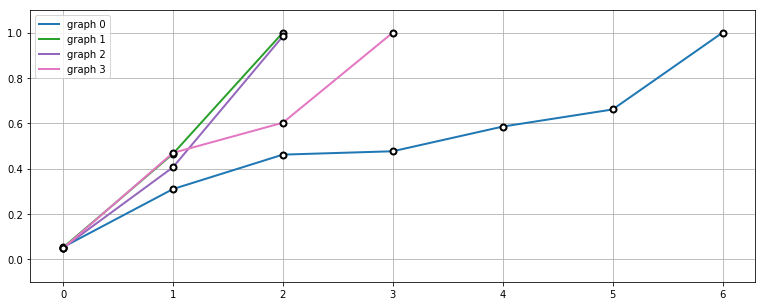

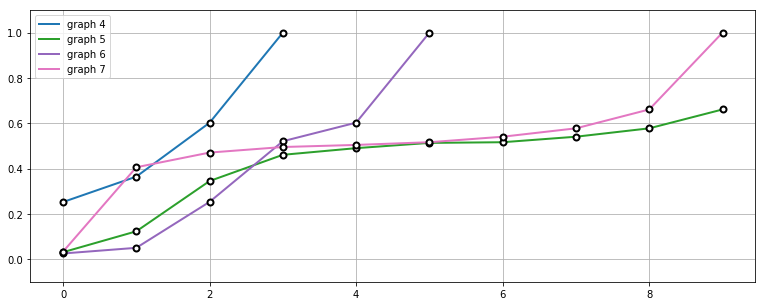


Graph id: 0


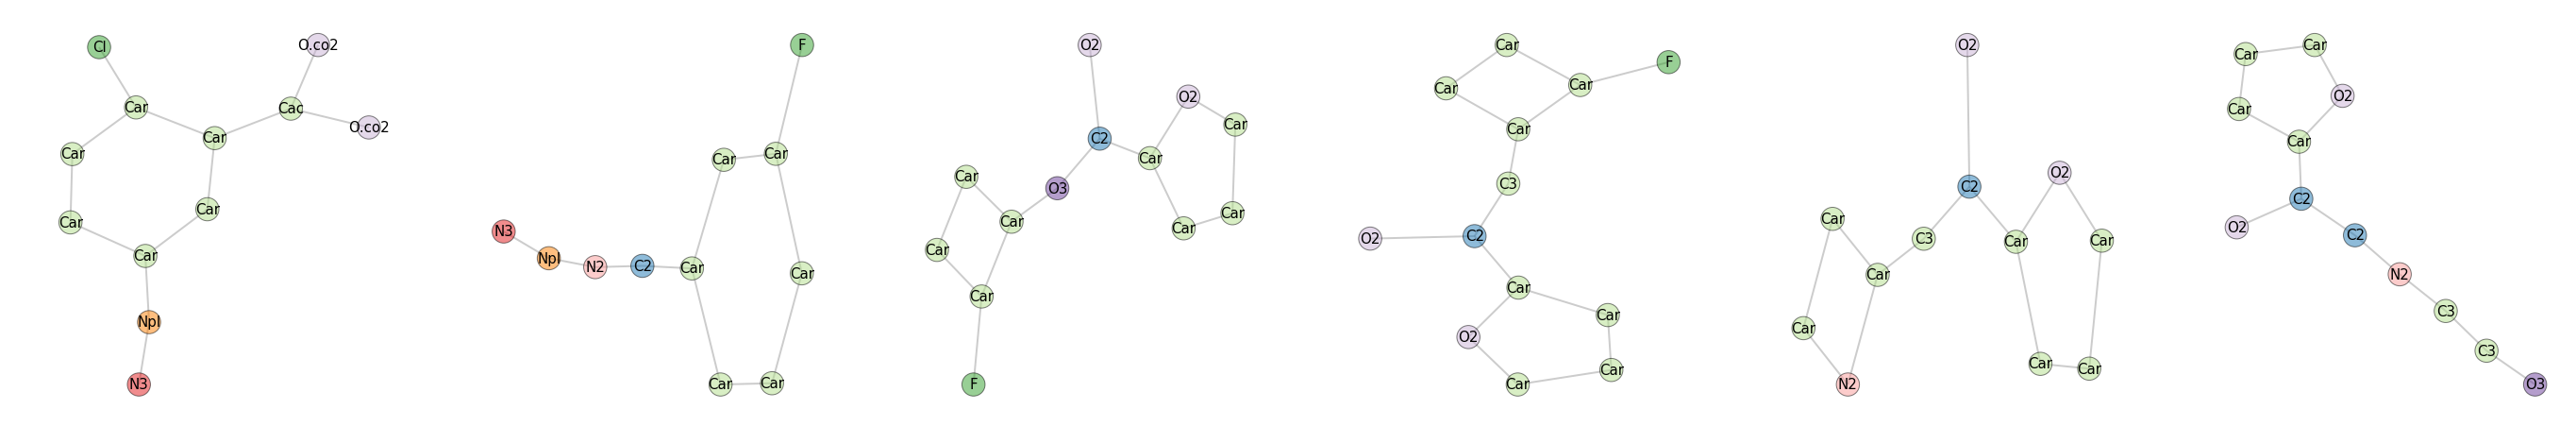

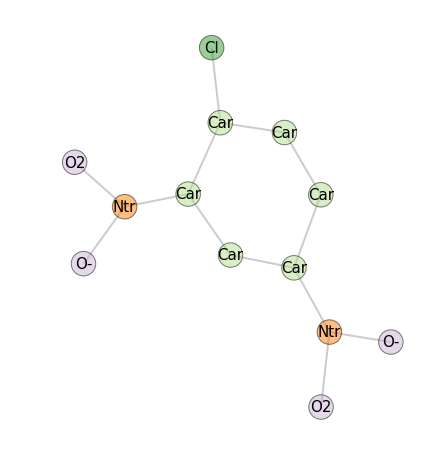


Graph id: 1


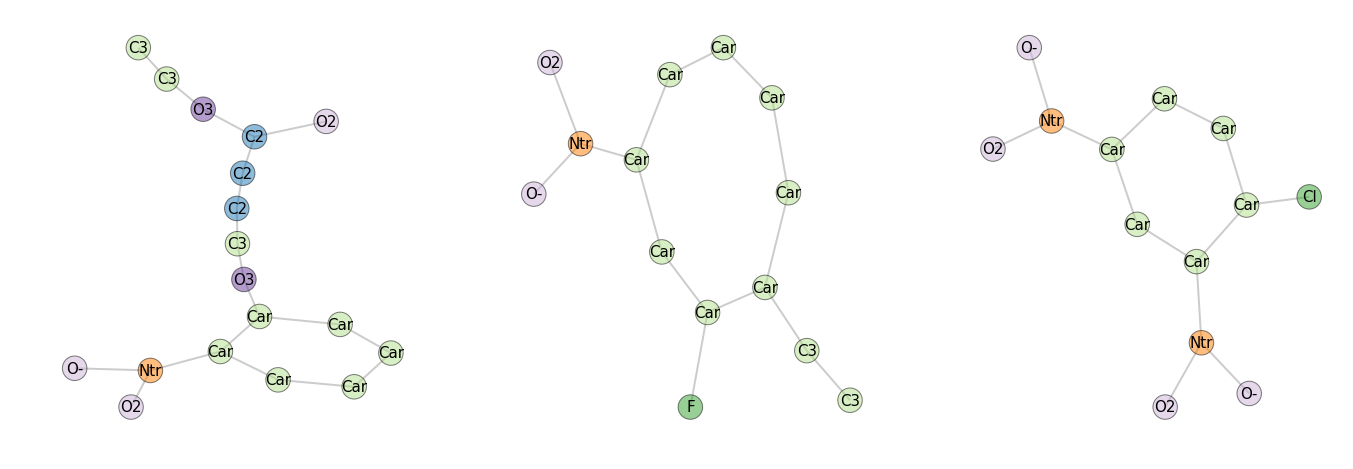


Graph id: 2


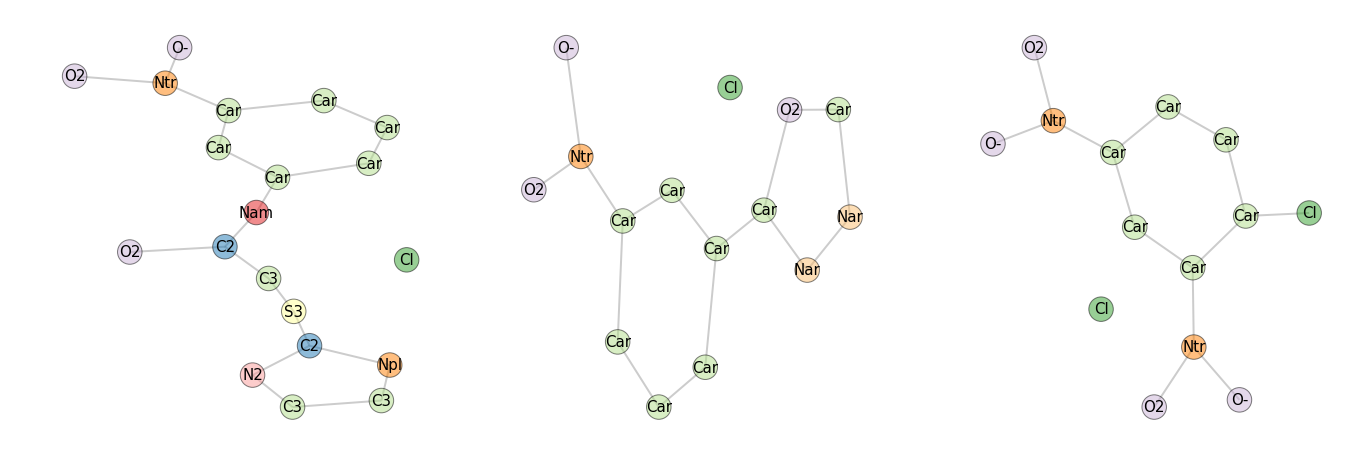


Graph id: 3


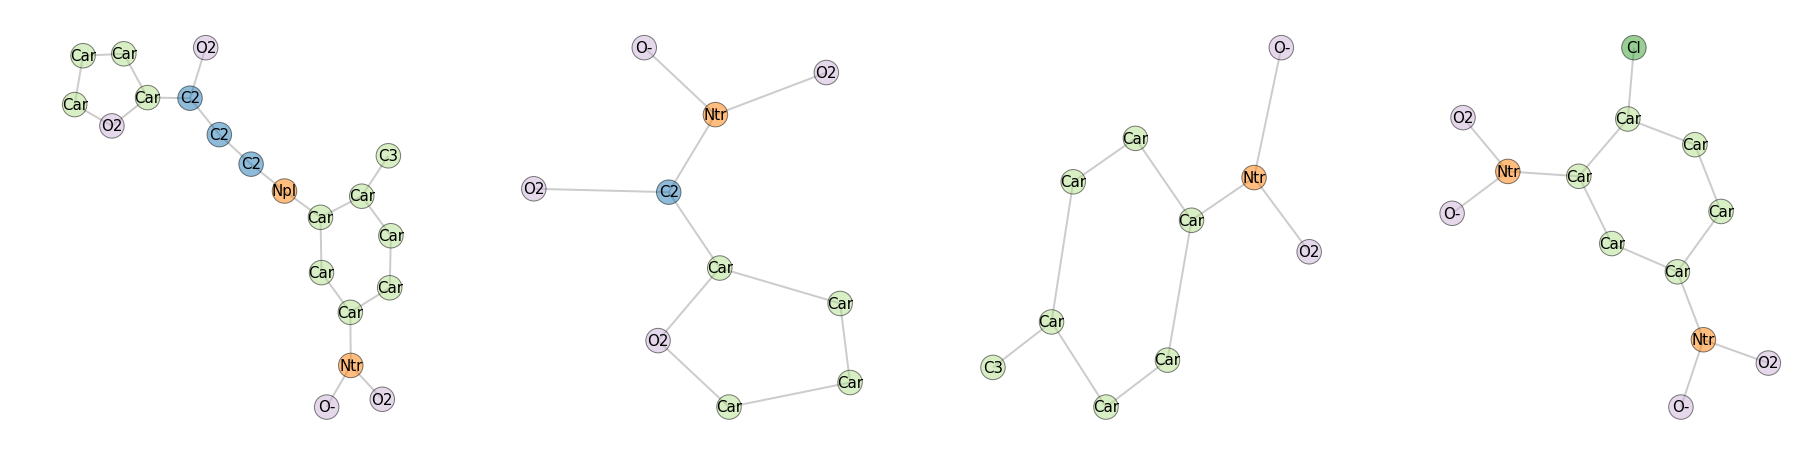


Graph id: 4


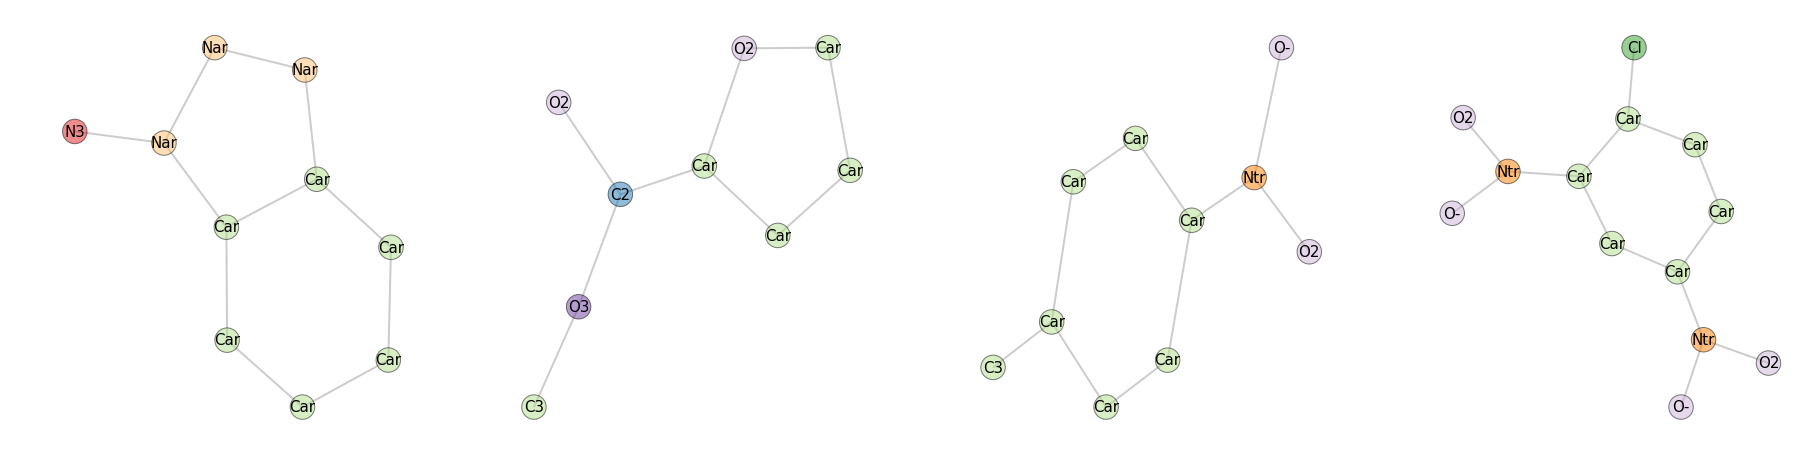


Graph id: 5


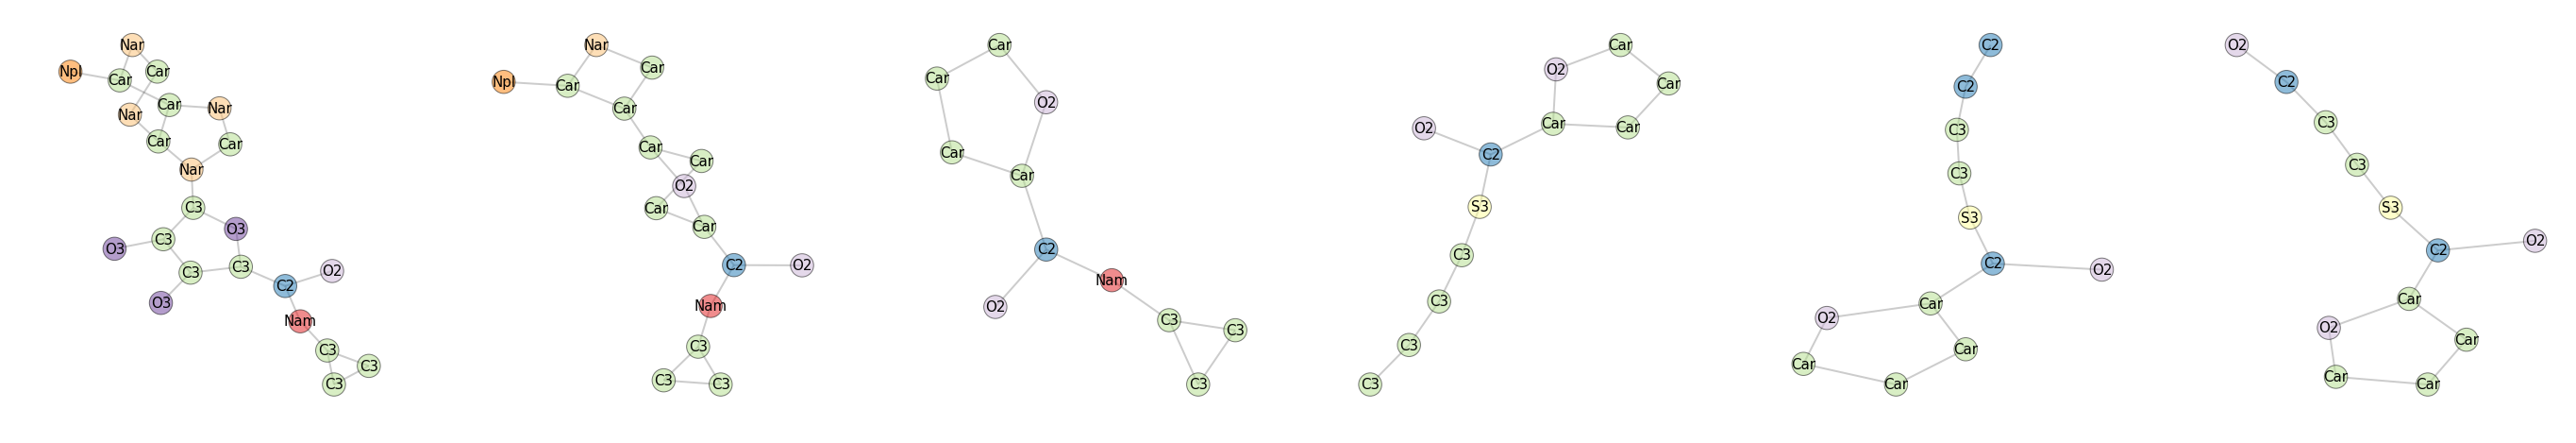

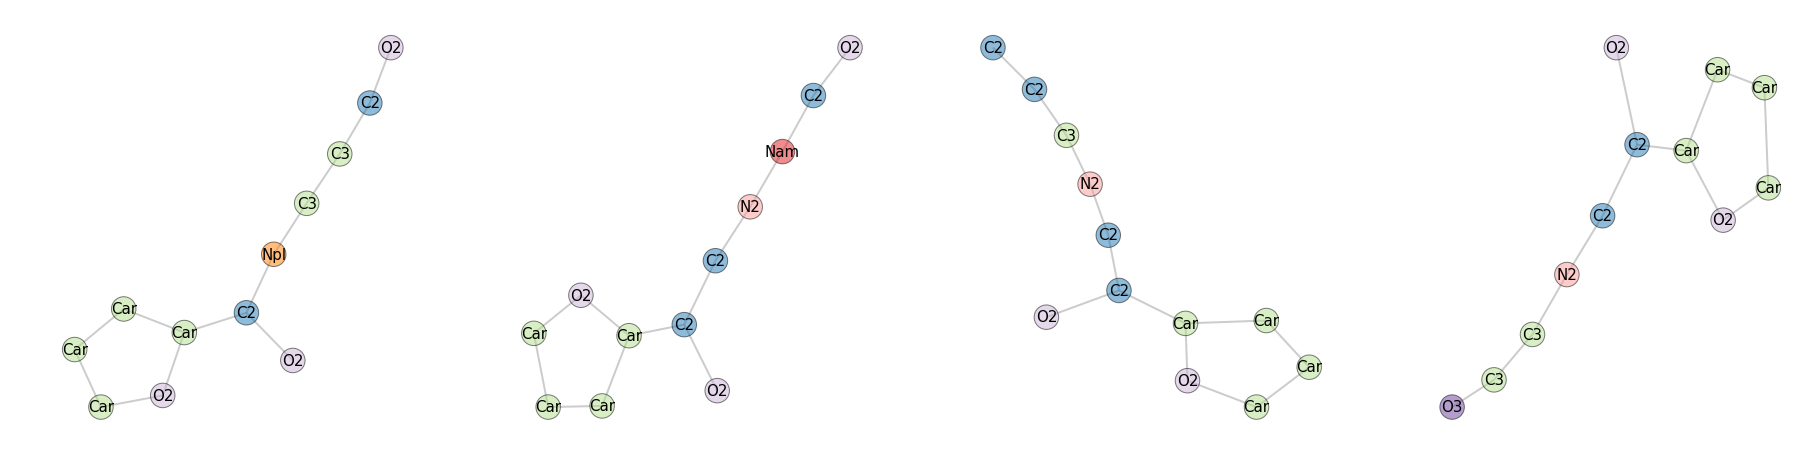


Graph id: 6


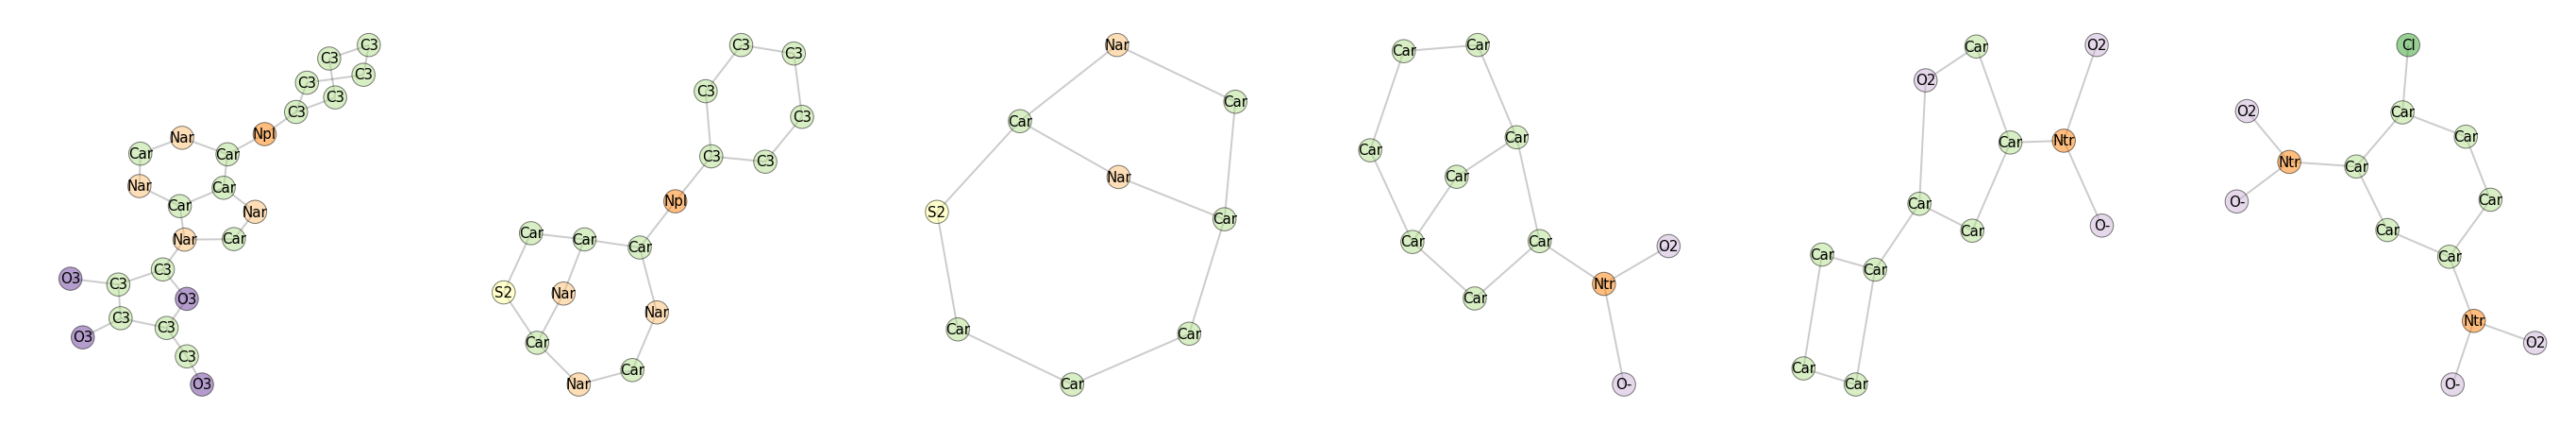


Graph id: 7


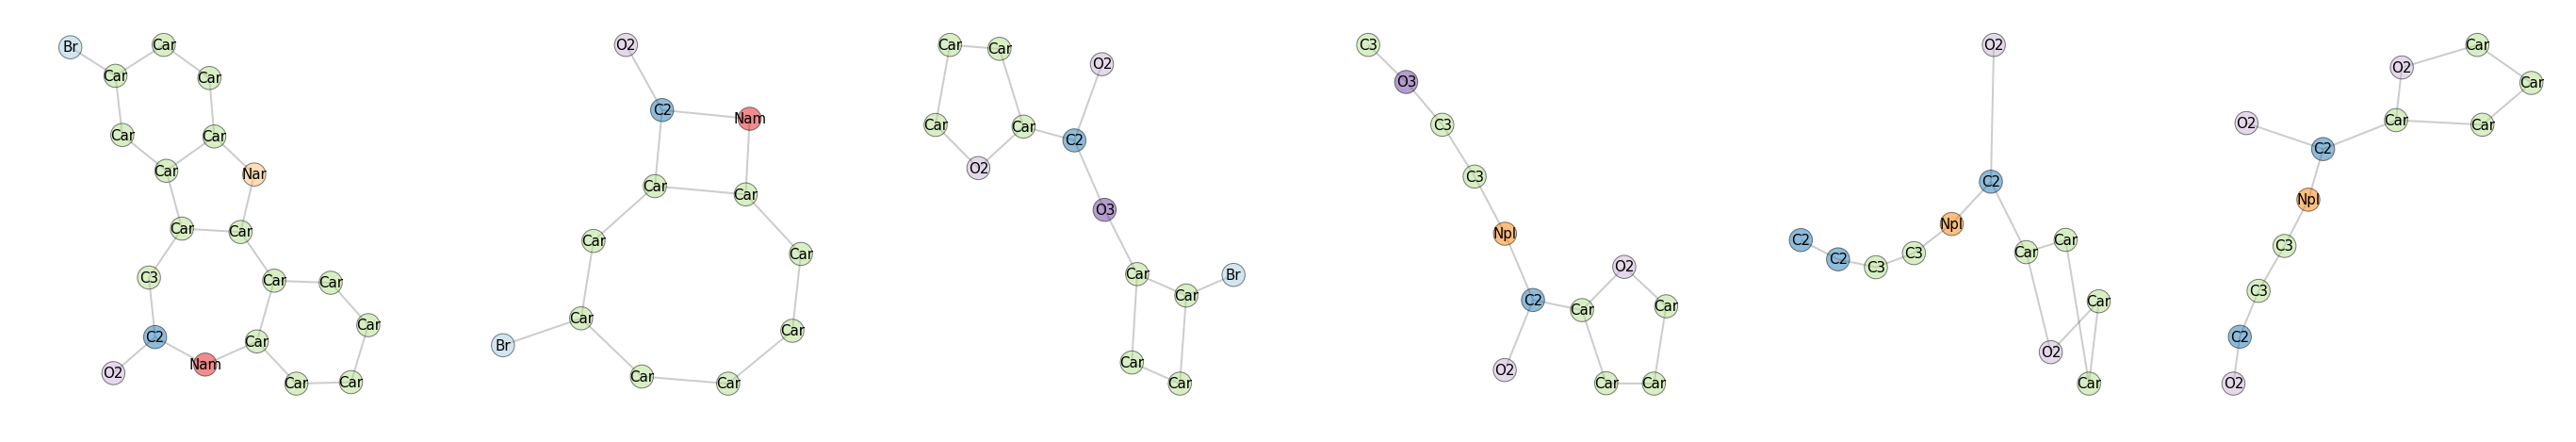

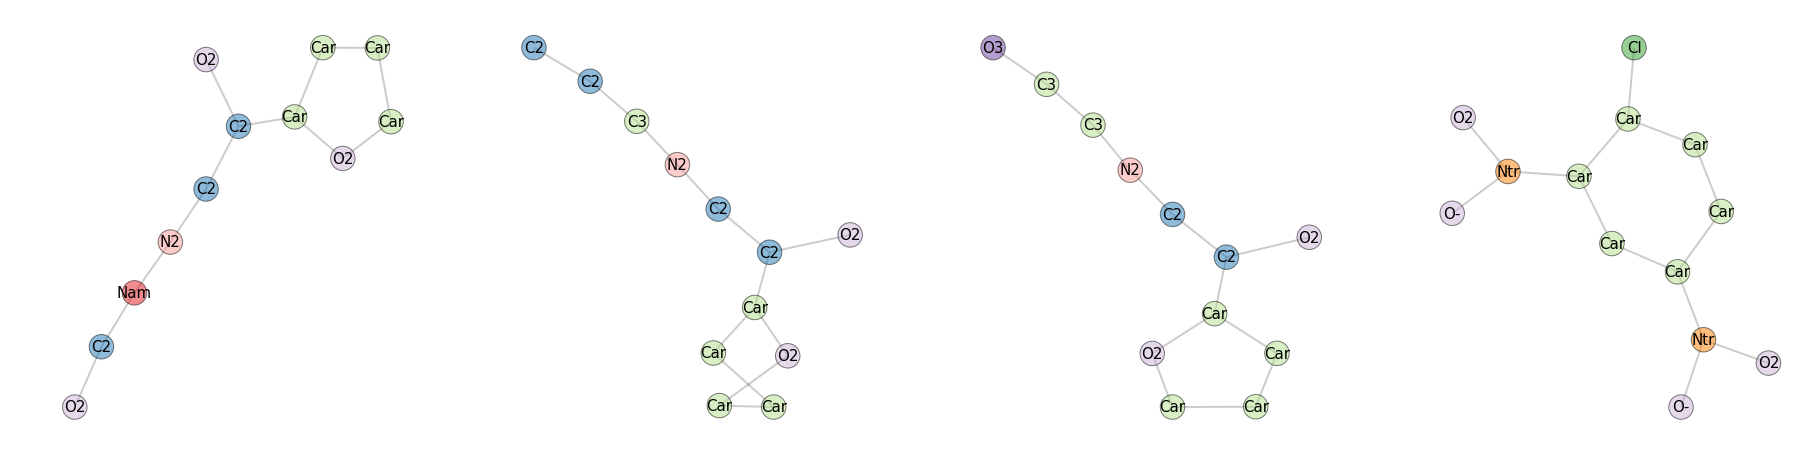

In [14]:
from graphlearn.utils import draw
def sample_graphs_scores_list_monotone_filter(sample_graphs_scores_list):
    scores = []
    sample_graphs_list = []
    for i, sample_graphs_scores in enumerate(sample_graphs_scores_list):
        _sample_graphs, _scores = sample_graphs_scores
        assert(len(_sample_graphs)==len(_scores))
        _score = []
        _graphs = []
        max_score = 0
        for s, g in zip(_scores, _sample_graphs[0]):
            if s > max_score:
                max_score = s
                _score.append(s)
                _graphs.append(g)
        scores.append(_score)
        sample_graphs_list.append(_graphs)
    return scores, sample_graphs_list

scores, sample_graphs_list = sample_graphs_scores_list_monotone_filter(sample_graphs_scores_list)
plot_scores(scores)
for i, sample_graphs in enumerate(sample_graphs_list):
    print('\nGraph id: %d'%(i))
    draw.graphlearn(sample_graphs, **draw_params)

---